In [1]:
# Machine learning
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression

# Data science
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn

# Other
import pickle
import os

## Loading models and data
We ran a script on a Google Cloud VM for about 4 days to collect over 100k samples (posts) from 3 different subreddits. Our first step is to load them into variables from the disk.

Last week, we trained models on the SCUT-FBP5500_v2 dataset. We must now load back in those trained models to perform analysis

In [3]:
# Load in the scraped data from reddit
pic_encodings, pic_metadata = np.load("encodings/pics_1425-050720.pkl", allow_pickle=True)
selfie_encodings, selfie_metadata = np.load("encodings/selfies_1647-050720.pkl", allow_pickle=True)
roastme_encodings, roast_metadata = np.load("encodings/roastme_1901-050820.pkl", allow_pickle=True)

In [2]:
# Train attractiveness rating predictors

# SCUT_encodings = np.load('SCUT-encodings.npy')
# SCUT_labels = np.load('SCUT-labels.npy')

# Load and train Neural Network
# network = MLPRegressor(validation_fraction = 0, solver='adam', max_iter= 1000).fit(SCUT_encodings, SCUT_labels)

# Load and train linear regression model
# linreg = LinearRegression().fit(SCUT_encodings, SCUT_labels)

# Load them in from pickles for speed
network = pickle.load(open('nn.pkl', 'rb'))
linreg = pickle.load(open('lr.pkl', 'rb'))

## Run ML Algorithms and Build DataFrames
Now that we have all of our data loaded into memory, we must use our machine learning algorithms to predict the attractiveness of each of our samples; this is done in the following cell.

After that, let's combine our attractiveness ratings with the upvote counts we scraped from each post into a DataFrame so we can analyze it more efficiently

In [4]:
# Predict ratings with linear regression model
lr_pic_ratings = linreg.predict(pic_encodings)
lr_selfie_ratings = linreg.predict(selfie_encodings)
lr_roastme_ratings =  linreg.predict(roastme_encodings)

# Predict ratings with Neural Network
nn_pic_ratings = network.predict(pic_encodings)
nn_selfie_ratings = network.predict(selfie_encodings)
nn_roastme_ratings = network.predict(roastme_encodings)

In [5]:
# Build dataframes from data
scores = lambda metadata: list(zip(*metadata))[2]  # get scores from metedata
pics_data = np.vstack((scores(pic_metadata), lr_pic_ratings, nn_pic_ratings)).T
selfies_data = np.vstack((scores(selfie_metadata), lr_selfie_ratings, nn_selfie_ratings)).T
roastme_data = np.vstack((scores(roast_metadata), lr_roastme_ratings, nn_roastme_ratings)).T

column_labels = ['Post Score', 'Lin Regr. Rating', 'NN Rating']
pics = pd.DataFrame(data=pics_data, columns=column_labels)
selfies = pd.DataFrame(data=selfies_data, columns=column_labels)
roastme = pd.DataFrame(data=roastme_data, columns=column_labels)

## Preliminary Visualizations
So far, we have our scraped data loaded in (facial encodings, reddit post scores), we calculated the predicted attractiveness for all our samples, and we formatted that data into Pandas dataframes for convenience.

Now, let's run some preliminary visualizations to see generally what our data really looks like.


### Attractiveness Distribution
First, let's check our assumptions that attractiveness will generally be normally distributed throughout our dataset.

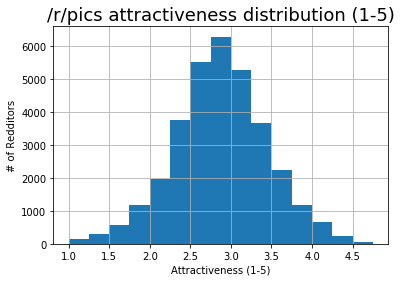

In [79]:
attr_bins = np.arange(1,5, .25)
pics['NN Rating'].hist(bins=attr_bins)
plt.xlabel("Attractiveness (1-5)")
plt.ylabel("# of Redditors")
plt.title("/r/pics attractiveness distribution (1-5)", size=18);

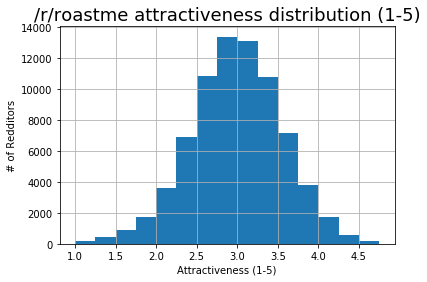

In [80]:
roastme['NN Rating'].hist(bins=attr_bins)
plt.xlabel("Attractiveness (1-5)")
plt.ylabel("# of Redditors")
plt.title("/r/roastme attractiveness distribution (1-5)", size=18);

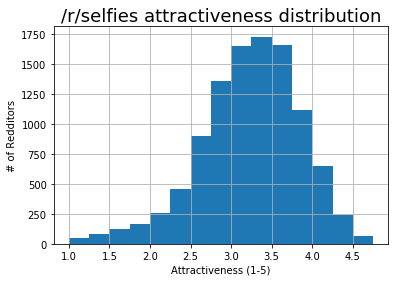

In [81]:
selfies['NN Rating'].hist(bins=attr_bins)
plt.xlabel("Attractiveness (1-5)")
plt.ylabel("# of Redditors")
plt.title("/r/selfies attractiveness distribution", size=18);

### Attractiveness Distribution Analysis
The attractiveness of /r/roastme and /r/pics strongly resembles a normal distribution, which is good. Interestingly enough, the attractiveness distribution of /r/selfies seems to be skewed towards higher attractiveness. Perhaps more attractive people are more likely to post a selfie of themself?

## Correlation
Now lets look at what we really care about: do more attractive people get more upvotes. i.e. is there a correlation between attractiveness and post score for our samples?

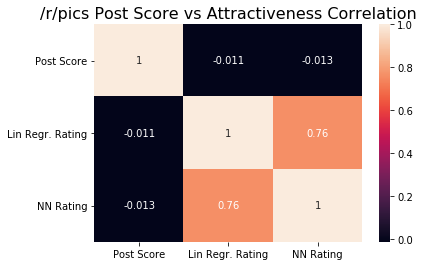

In [82]:
seaborn.heatmap(pics.corr(), annot=True)
plt.title('/r/pics Post Score vs Attractiveness Correlation', size=16);

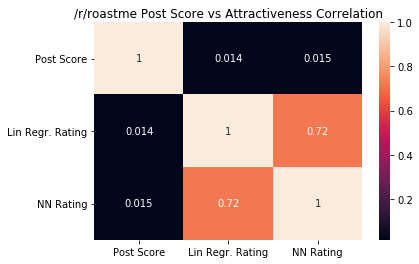

In [15]:
seaborn.heatmap(roastme.corr(), annot=True)
plt.title('/r/roastme Post Score vs Attractiveness Correlation', size=16));

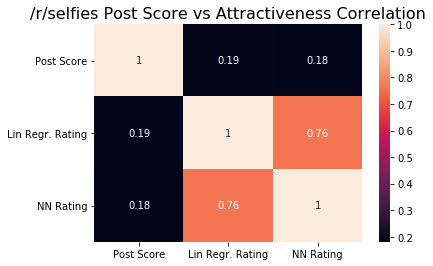

In [85]:
seaborn.heatmap(selfies.corr(), annot=True)
plt.title('/r/selfies Post Score vs Attractiveness Correlation', size=16);

### Correlation analysis
What we are looking at in these graphs is the first row/column: it shows the correlation between post score and the attractiveness ratings each predictor assigned the samples. Interstingly enough, there is not strong correlation between the scores and the attractiveness ratings. 

However, it's interesting to see that /r/selfies had a correlation coefficient ~20 times higher than the other two subreddits. Combined with that subreddit's skew towards more attractive posters, perhaps one could say that /r/selfies values beauty more than the other two subreddits?

count    75612.000000
mean       160.368539
std       1844.721790
min          0.000000
25%          1.000000
50%          1.000000
75%          8.000000
max      94582.000000
Name: Post Score, dtype: float64